In [6]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

In [33]:
def create_Rzyz(phi, theta, psi):
    rz1 = create_Rz(phi)
    ry = create_Ry(theta)
    rz2 = create_Rz(psi)
    r_zyz = np.einsum('...ij,...jk->...ik',rz2,np.einsum('...ij,...jk->...ik',ry,rz1))
    return r_zyz


def create_Rz(angles):
    rz = np.zeros((*angles.shape,3,3))
    tmp_cos = np.cos(angles)
    tmp_sin = np.sin(angles)
    rz[...,0,0] = tmp_cos
    rz[...,1,1] = tmp_cos
    rz[...,1,0] = tmp_sin
    rz[...,0,1] = -tmp_sin
    rz[...,2,2] = 1
    return rz

def create_Ry(angles):
    ry = np.zeros((*angles.shape,3,3))
    tmp_cos = np.cos(angles)
    tmp_sin = np.sin(angles)
    ry[...,0,0] = tmp_cos
    ry[...,2,2] = tmp_cos
    ry[...,2,0] = -tmp_sin
    ry[...,0,2] = tmp_sin
    ry[...,1,1] = 1
    return ry

def create_Rx(angles):
    rx = np.zeros((*angles.shape,3,3))
    tmp_cos = np.cos(angles)
    tmp_sin = np.sin(angles)
    rx[...,0,0] = 1
    rx[...,1,1] = tmp_cos
    rx[...,2,2] = tmp_cos
    rx[...,2,1] = tmp_sin
    rx[...,1,2] = -tmp_sin
    return rx

def create_Rx_cp(angles):
    rx = cp.zeros((*angles.shape,3,3))
    tmp_cos = cp.cos(angles)
    tmp_sin = cp.sin(angles)
    rx[...,0,0] = 1
    rx[...,1,1] = tmp_cos
    rx[...,2,2] = tmp_cos
    rx[...,2,1] = tmp_sin
    rx[...,1,2] = -tmp_sin
    return rx

In [27]:
create_Rx_nb = nb.njit(create_Rx)

In [29]:
angle1 = np.zeros((1,2048,2048),dtype=np.float32)

In [30]:
%timeit create_Rx(angle1)

171 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%timeit create_Rx_nb(angle1)

236 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
angle1_cp = cp.asarray(angle1)

In [35]:
%timeit create_Rx_cp(angle1_cp)

94.2 µs ± 17.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
171*1000/94.2

1815.2866242038217

In [3]:
phi = np.zeros((2,2))
theta = np.ones((2,2))*np.pi/2
psi = np.ones((2,2))*np.pi/4
r_zyz = create_Rzyz(phi,theta,psi)

In [4]:
perp1 = .75
para1 = 1.5

iso = (2*perp1 + para1)/3

In [5]:
array1 = np.zeros((3,3))
array1[0,0] = perp1
array1[1,1] = perp1
array1[2,2] = para1

array2 = np.zeros((3,3))
np.fill_diagonal(array2,iso)

In [6]:
np.round(r_zyz[0,0]@array1@r_zyz[0,0].T,10)

array([[1.125, 0.375, 0.   ],
       [0.375, 1.125, 0.   ],
       [0.   , 0.   , 0.75 ]])

In [7]:
np.round(r_zyz[0,0]@array2@r_zyz[0,0].T,10)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [8]:
S = 0.75
Evec = np.array([1,0,0],dtype=complex)

In [9]:
combined_array = S*array1 + (1-S)*array2

In [10]:
(combined_array@combined_array-np.identity(3))@Evec

array([-0.33984375+0.j,  0.        +0.j,  0.        +0.j])

In [11]:
S*(array1@array1-np.identity(3))@Evec + (1-S)*(array2@array2-np.identity(3))@Evec

array([-0.328125+0.j,  0.      +0.j,  0.      +0.j])

In [47]:
from sympy import symbols, Matrix
from sympy.physics.quantum import TensorProduct
from sympy.physics.quantum.operator import OuterProduct

In [48]:
kx, ky, kz, qx, qy, qz = symbols('kx ky kz qx qy qz')
k0, px, py, pz = symbols('k0 px py pz')

In [49]:
r = Matrix([kx+qx,ky+qy,kz+qz])
p = Matrix([px, py, pz])
I = Matrix([[1,0,0],[0,1,0],[0,0,1]])
rr = TensorProduct(r/k0,r.T/k0)
k0**2*(I-rr)

Matrix([
[k0**2*(1 - (kx + qx)**2/k0**2),           -(kx + qx)*(ky + qy),           -(kx + qx)*(kz + qz)],
[          -(kx + qx)*(ky + qy), k0**2*(1 - (ky + qy)**2/k0**2),           -(ky + qy)*(kz + qz)],
[          -(kx + qx)*(kz + qz),           -(ky + qy)*(kz + qz), k0**2*(1 - (kz + qz)**2/k0**2)]])

In [50]:
k0**2*(I-rr)@p

Matrix([
[k0**2*px*(1 - (kx + qx)**2/k0**2) - py*(kx + qx)*(ky + qy) - pz*(kx + qx)*(kz + qz)],
[k0**2*py*(1 - (ky + qy)**2/k0**2) - px*(kx + qx)*(ky + qy) - pz*(ky + qy)*(kz + qz)],
[k0**2*pz*(1 - (kz + qz)**2/k0**2) - px*(kx + qx)*(kz + qz) - py*(ky + qy)*(kz + qz)]])

In [15]:
qx = np.fft.fftshift(np.fft.fftfreq(50))
qy = qx.copy()
qz = np.fft.fftshift(np.fft.fftfreq(10))

In [16]:
qzz, qyy, qxx = np.meshgrid(qz, qy, qx, indexing='ij')

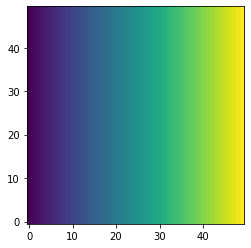

In [17]:
plt.imshow(qxx[0,...],origin='lower')

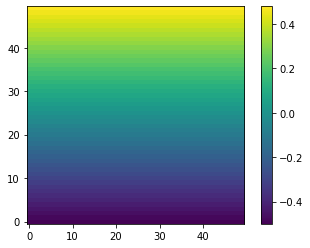

In [18]:
plt.imshow(qyy[0,...],origin='lower')
plt.colorbar()

In [25]:
real_space = np.zeros(513)
real_space[16:48] = 1

In [26]:
q = np.fft.fftshift(np.fft.fftfreq(real_space.size))
recip_space = np.fft.fftshift(np.fft.fft(real_space))

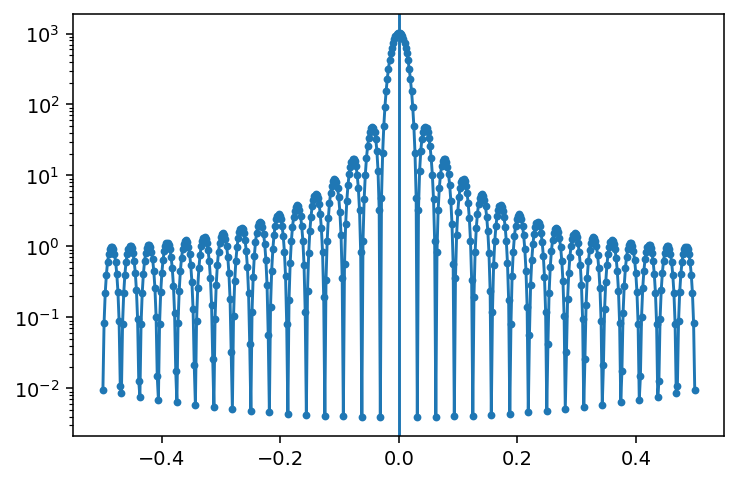

In [27]:
plt.figure(dpi=140)
plt.semilogy(q,np.abs(recip_space)**2,'.-')
# plt.xlim(-0.02,0.02)
plt.axvline(x=0)

In [65]:
def calculate_farfield(Pq, k, PhysSize):
    '''
    input:
        Pq - Induced polarization in Fourier Space (NumZ, NumY, NumX, 3)
        k - x-ray propagation vector (3,)
    
    output:
        Iscatter - Scattering intensity which is the magnitude squared of 
                    the far-field projection of the electric field
    '''

    kmag = np.sqrt(np.sum(k**2))
    # Calculate Scattering Vectors
    qz = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(Pq.shape[0],d=PhysSize))
    qy = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(Pq.shape[1],d=PhysSize))
    qx = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(Pq.shape[2],d=PhysSize))
    

    qzz, qyy, qxx = np.meshgrid(qz, qy, qx, indexing='ij')
    kxqx = k[0] - qxx
    kyqy = k[1] - qyy
    kzqz = k[2] - qzz

    escat_x = (Pq[...,0]*(kmag**2-kxqx**2) 
                - Pq[...,1]*kxqx*kyqy 
                - Pq[...,2]*kxqx*kzqz)

    escat_y = (Pq[...,1]*(kmag**2 - kyqy**2)
                - Pq[...,0]*kxqx*kyqy
                - Pq[...,2]*kyqy*kzqz)

    escat_z = (Pq[...,2]*(kmag**2 - kzqz**2)
                - Pq[...,0]*kxqx*kyqy
                - Pq[...,1]*kyqy*kzqz)

    Iscatter = np.abs(escat_x)**2 + np.abs(escat_y)**2 + np.abs(escat_z)**2
    
    return Iscatter



def calculate_farfield_nb(Pq, k, PhysSize):
    '''
    input:
        Pq - Induced polarization in Fourier Space (3, NumZ, NumY, NumX)
        k - x-ray propagation vector (3,)
    
    output:
        Iscatter - Scattering intensity which is the magnitude squared of 
                    the far-field projection of the electric field
    '''

    kmag = np.sqrt(np.sum(k**2))
    # Calculate Scattering Vectors
    qz = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(Pq.shape[1],d=PhysSize))
    qy = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(Pq.shape[2],d=PhysSize))
    qx = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(Pq.shape[3],d=PhysSize))
    

    qzz, qyy, qxx = np.meshgrid(qz, qy, qx, indexing='ij')
    kxqx = k[0] - qxx
    kyqy = k[1] - qyy
    kzqz = k[2] - qzz

    escat_x = (Pq[0,...]*(kmag**2-kxqx**2) 
                - Pq[1,...]*kxqx*kyqy 
                - Pq[2,...]*kxqx*kzqz)

    escat_y = (Pq[1,...]*(kmag**2 - kyqy**2)
                - Pq[0,...]*kxqx*kyqy
                - Pq[2,...]*kyqy*kzqz)

    escat_z = (Pq[2,...]*(kmag**2 - kzqz**2)
                - Pq[0,...]*kxqx*kyqy
                - Pq[1,...]*kyqy*kzqz)

    Iscatter = np.abs(escat_x)**2 + np.abs(escat_y)**2 + np.abs(escat_z)**2
    
    return Iscatter


In [35]:
x = np.arange(-128,128)
y = x.copy()
z = x.copy()

In [36]:
zz, yy, xx = np.meshgrid(z,y,x,indexing='ij')
sphere = np.zeros(zz.shape)
radius = 25
idx = zz**2 + yy**2 + xx**2 < radius**2
sphere[idx] = 1
sphere_recip = np.fft.fftshift(np.fft.fftn(sphere))

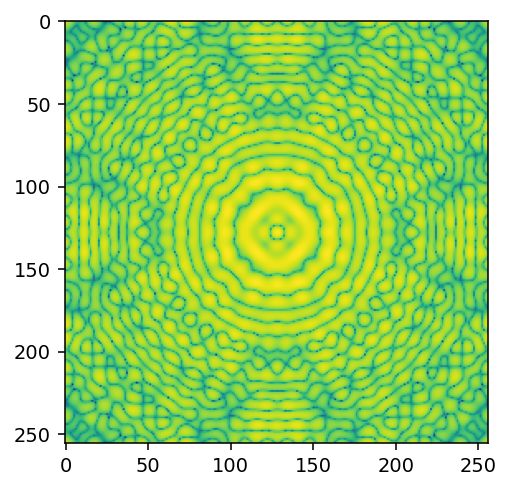

In [40]:
plt.figure(dpi=140)
plt.imshow(np.log(np.abs(sphere_recip[64,...])**2))

In [107]:
@nb.njit(parallel=True)
def nb_einsum_begin(array1,array2):
    
    shape = array1.shape
    array1 = np.reshape(array1,(3,3,shape[2]*shape[3]*shape[4]))
    array2 = np.reshape(array2,(3,3,-1))
    result = np.zeros(array1.shape)
    
    for s in nb.prange(array1.shape[2]):
        for i in range(3):
            for k in range(3):
                acc = 0
                for j in range(3):
                    acc += array1[i,j,s]*array2[j,k,s]
                result[i,k,s] = acc
                
    result = np.reshape(result,shape)
    return result

@nb.njit(parallel=True)
def nb_einsum_end(array1,array2):
    
    shape = array1.shape
    array1 = np.reshape(array1,(shape[0]*shape[1]*shape[2],3,3))
    array2 = np.reshape(array2,(shape[0]*shape[1]*shape[2],3,3))
    result = np.zeros(array1.shape)
    
    for s in nb.prange(array1.shape[0]):
        for i in range(3):
            for k in range(3):
                acc = 0
                for j in range(3):
                    acc += array1[s,i,j]*array2[s,j,k]
                result[s,i,k] = acc
                
    # result = np.reshape(result,shape)
    return result

@nb.njit(parallel=True)
def nb_einsum_1D(array1,array2):
    
    Z, Y, X, col, row = array1.shape
    array1 = array1.ravel()
    array2 = array2.ravel()
    result = np.zeros(array1.shape)
    
    
    for s in nb.prange(Z*Y*X):
        for i in range(3):
            for k in range(3):
                acc = 0
                for j in range(3):
                    acc += array1[s*9 + i*3 + j]*array2[s*9 + j*3 + k]
                result[s*9 + i*3 + k] = acc
                
    # result = np.reshape(result,(Z, Y, X, col, row))
    return result

In [61]:
from numba import cuda, float32, complex64

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
# TPB = 3

@cuda.jit
def matmul(A,B,C):
    '''
    Naive cuda implementation of matrix multiplication for arrays of size [N, 3, 3]. The matrix multiplication occurs over the last two axes.
    
    Parameters
    ----------
    
    A : cuda or cupy array
        Input array 1
    B : cuda or cupy array
        Input array 2
    C : cuda or cupy array
        Output array
    '''
    i, j, k = cuda.grid(3)
    # stride = cuda.gridsize(1)
    
    if i < A.shape[0]:
        if (j < 3) & (k < 3):
            C[i,j,k] = A[i,j,0]*B[i,0,k] + A[i,j,1]*B[i,1,k] + A[i,j,2]*B[i,2,k]

                
@cuda.jit
def rotate_n_gpu(n, rotmat, result1, n_rotated):
    '''
    input:
        n : ndarray
            Aligned optical tensor (biaxial or uniaxial) [3,3]
        rotmat : ndarray
            Reshaped rotation matrices [NumZ*NumY*NumX, 3, 3]
        result1 : ndarray
            Stores intermediate calculation result [NumZ*NumY*NumX, 3, 3]
        n_rotated : ndarray
            n-dimensional array of rotated optical tensors [NumZ*NumY*NumX, 3, 3]
    '''
    s = cuda.grid(1)
    if s < rotmat.shape[0]:
        for i in range(3):
            for k in range(3):
                result1[s,i,k] = n[i,0]*rotmat[s,k,0] + n[i,1]*rotmat[s,k,1] + n[i,2]*rotmat[s,k,2]
                
                
    s = cuda.grid(1)
    if s < rotmat.shape[0]:
        for i in range(3):
            for k in range(3):
                n_rotated[s,i,k] = rotmat[s,i,0]*result1[s,0,k] + rotmat[s,i,1]*result1[s,1,k] + rotmat[s,i,1]*result1[s,1,k]
                
@cuda.jit
def rotate_n_gpu_gs(n, rotmat, result1, n_rotated):
    '''
    input:
        n : ndarray
            Aligned optical tensor (biaxial or uniaxial) [3,3]
        rotmat : ndarray
            Reshaped rotation matrices [NumZ*NumY*NumX, 3, 3]
        result1 : ndarray
            Stores intermediate calculation result [NumZ*NumY*NumX, 3, 3]
        n_rotated : ndarray
            n-dimensional array of rotated optical tensors [NumZ*NumY*NumX, 3, 3]
    '''
    
    sA = cuda.shared.array((3,3),dtype=complex64)
    for i in range(3):
        for j in range(3):
            sA[i,j] = n[i,j]

    pos = cuda.grid(1)
    stride = cuda.gridsize(1)
    for s in range(pos,rotmat.shape[0],stride):
        for i in range(3):
            for k in range(3):
                acc = 0
                for j in range(3):
                    acc += sA[i,j]*rotmat[s,k,j]
                result1[s,i,k] = acc
                
    pos = cuda.grid(1)
    stride = cuda.gridsize(1)
    for s in range(pos,rotmat.shape[0],stride):
        for i in range(3):
            for k in range(3):
                acc = 0
                for j in range(3):
                    acc += rotmat[s,i,j]*result1[s,j,k]
                n_rotated[s,i,k] = acc

@cuda.jit
def rotate_n_kernel_t3(n, rotmat, result1, n_rotated):
    '''
    Naive cuda kernel for rotating [3,3] optical tensor across morphology array.
    Performs successive contractions of 'ij,akj->aik' and 'aij,ajk->aik'. Equivalent to R@n@R.T.

    Parameters
    ----------
        n : ndarray
            Aligned optical tensor (biaxial or uniaxial) [3,3]
        rotmat : ndarray
            Reshaped rotation matrices [NumZ*NumY*NumX, 3, 3]
        result1 : ndarray
            Stores intermediate calculation result [NumZ*NumY*NumX, 3, 3]
        n_rotated : ndarray
            n-dimensional array of rotated optical tensors [NumZ*NumY*NumX, 3, 3]
    '''
    x, y, z = cuda.grid(3)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    tz = cuda.threadIdx.z

    stride, _, _ = cuda.gridsize(3)    # blocks per grid
    for pos in range(x,rotmat.shape[0],stride):
        result1[pos,ty,tz] = n[ty,0]*rotmat[pos,tz,0] + n[ty,1]*rotmat[pos,tz,1] + n[ty,2]*rotmat[pos,tz,2]
    
    cuda.syncthreads()
              
    for pos in range(x,rotmat.shape[0],stride):
        n_rotated[pos,ty,tz] = rotmat[pos,ty,0]*result1[pos,0,tz] + rotmat[pos,ty,1]*result1[pos,1,tz] + rotmat[pos,ty,2]*result1[pos,2,tz]

In [8]:
TPB = 16

@cuda.jit
def fast_matmul(A, B, C):
    """
    Perform matrix multiplication of C = A * B using CUDA shared memory.

    Reference: https://stackoverflow.com/a/64198479/13697228 by @RobertCrovella
    """
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(3, 3), dtype=float32)
    sB = cuda.shared.array(shape=(3, 3), dtype=float32)

    x, y, z = cuda.grid(3)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    tz = cuda.threadIdx.z
    
    stride, _, _ = cuda.gridsize(3)    # blocks per grid
    for pos in range(x,A.shape[0],stride):
        # Each thread computes one element in the result matrix.
        # The dot product is chunked into dot products of TPB-long vectors.
        tmp = float32(0.)

        # Preload data into shared memory
        sA[ty, tx] = 0
        sB[ty, tx] = 0

        sA[ty, tx] = A[pos, ty, tx]
        sB[ty, tx] = B[pos, ty, tx]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(3):
            tmp += sA[ty, j] * sB[j, tx]

        # Wait until all threads finish computing
        cuda.syncthreads()

        C[pos, y, x] = tmp

In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensornet'

In [3]:
from cupyx.profiler import benchmark

In [4]:
import cupy as np
from numba import cuda, float32, complex64, void

def einsum_gpu(array1, array2, TPB_x = 32):
    '''
    Performs the matrix contraction '...ij,...jk->...ik'

    Parameters
    ----------
        array1 : ndarray
            n-dimensional array, where the last two dimension sizes are 3
        array2 : ndarray
            n-dimensional array where the last two dimensions sizes are 3
    
    Returns
    -------
        array_out : ndarray
            n-dimensional array of the same shape as array1 & array 2
    '''
    shape = array1.shape
    #reshape arrays to [NumZ*NumY*NumX, 3, 3]
    array1 = np.reshape(array1, (-1,3,3))
    array2 = np.reshape(array2, (-1,3,3))
    #allocate array to return
    array_out = cuda.device_array(array1.shape,dtype=np.float32)

    #define TPB and BPG for execution on GPU
    threadsperblock = (TPB_x, 3, 3)
    blockspergrid = (int(np.ceil(array1.shape[0]/TPB_x)), 1, 1)
    einsum_kernel[blockspergrid, threadsperblock](array1, array2, array_out)
    # reshape to [NumZ, NumY, NumX, 3, 3]
    array_out = np.reshape(array_out,shape)
    return array_out

@cuda.jit(void(float32[:,:,:],float32[:,:,:],float32[:,:,:]))
def einsum_kernel(A,B,C):
    '''
    Cuda kernel for matrix multiplication of size [N, 3, 3]. 
    Performs the matrix contraction 'aij,ajk->aik'.
         
    Parameters
    ----------
    
    A : cuda or cupy array
        Input array 1
    B : cuda or cupy array
        Input array 2
    C : cuda or cupy array
        Output array
    
    '''
    x, y, z = cuda.grid(3)

    ty = cuda.threadIdx.y
    tz = cuda.threadIdx.z
    
    stride, _, _ = cuda.gridsize(3)    # blocks per grid
    for pos in range(x,A.shape[0],stride):
        C[pos, ty, tz] = A[pos, ty, 0] * B[pos, 0, tz] + A[pos, ty, 1] * B[pos, 1, tz] + A[pos, ty, 2] * B[pos, 2, tz]

In [2]:
array1 = np.random.rand(1,512,512,3,3,dtype=np.float32)
array2 = np.random.rand(1,512,512,3,3,dtype=np.float32)

In [5]:
def cupy_einsum(array1, array2):
    return np.einsum('...ij,...jk->...ik',array1,array2)

In [6]:
benchmark(cupy_einsum,(array1,array2),n_repeat=100)

cupy_einsum         :    CPU:  201.592 us   +/-75.429 (min:  180.292 / max:  939.194) us     GPU-0: 3437.801 us   +/-334.405 (min: 2854.304 / max: 4610.464) us

In [7]:
benchmark(einsum_gpu,(array1,array2),n_repeat=100)

einsum_gpu          :    CPU:  552.730 us   +/-265.568 (min:  345.907 / max: 1540.566) us     GPU-0:  677.267 us   +/-238.247 (min:  371.808 / max: 1475.712) us

In [8]:
start_gpu = np.cuda.Event()
end_gpu = np.cuda.Event()
t_gpu = np.zeros(50)
for i in range(50):
    start_gpu.record()
    out_1 = einsum_gpu(array1,array2,TPB_x=32)
    end_gpu.record()
    end_gpu.synchronize()
    t_gpu[i] = np.cuda.get_elapsed_time(start_gpu, end_gpu)
print(t_gpu)
print(' ')
print(np.mean(t_gpu[1:]))

[1.33024001 0.61440003 0.61027199 0.53187197 0.533472   0.52127999
 0.51744002 0.52838397 0.524544   0.51670402 0.52025598 0.99360001
 0.560224   0.55449599 0.55494398 0.719616   0.53132802 1.21497595
 0.56256002 0.72278398 0.62057602 0.72662401 1.61440003 0.86921602
 0.63551998 0.65497601 0.72441602 0.670816   0.53824002 0.56115198
 0.55216002 0.55481601 0.55712003 1.14240003 0.57753599 0.57696003
 0.57814401 0.55721599 0.53452802 0.72499198 0.57036799 0.560224
 0.53862399 0.57923198 1.10934401 0.57817602 0.57344002 0.593952
 0.556512   0.54249603]
 
0.653210778625644


In [9]:
start_gpu = np.cuda.Event()
end_gpu = np.cuda.Event()
t_gpu = np.zeros(50)
for i in range(50):
    start_gpu.record()
    out_2 = np.einsum('...ij,...jk->...ik',array1,array2)
    end_gpu.record()
    end_gpu.synchronize()
    t_gpu[i] = np.cuda.get_elapsed_time(start_gpu, end_gpu)
print(t_gpu)
print(' ')
print(np.mean(t_gpu[1:]))

[4.41535997 3.83839989 3.90899205 4.11033583 4.71964788 4.75750399
 4.27004814 3.72063994 3.79907203 4.07622385 3.71529603 3.836128
 3.693856   3.72630405 4.05852795 4.02179193 4.10182381 4.77129602
 4.11520004 3.78083205 3.97107196 4.90678406 3.76646399 3.96736002
 4.93945599 4.7309761  3.83846402 3.75190401 3.7703681  4.72473621
 4.75395203 3.45228791 3.64032006 3.92854404 3.75808001 3.98108792
 4.72678423 4.71484804 4.02022409 3.76854396 3.40400004 3.54096007
 4.07539177 3.96697593 3.40463996 3.52201605 3.83804798 4.16764784
 3.5246079  3.52150393]
 
4.022448320778048


In [10]:
np.allclose(out_1,out_2)

array(True)

In [11]:
def rotate_n_gpu(n,rotmat, TPB_x = 32):
    '''
    Rotates the complex optical tensor using a rotation matrix

    Parameters
    ----------
        n : 3x3 array, complex
            Complex optical tensor of the form n = 1 - delta + i*beta
        rotmat : ndarray
            Rotation matrices for each voxel in the morphology [NumZ, NumY, NumX, 3, 3]
    
    Returns
    -------
        n_rotated : ndarray, complex
            Rotated complex optical tensor for each voxel in the morphology [NumZ, NumY, NumX, 3, 3]
    '''
    shape = rotmat.shape
    #reshape arrays to [NumZ*NumY*NumX, 3, 3]
    rotmat = np.reshape(rotmat,(-1,3,3))
    #allocated intermediate and final arrays
    result1 = cuda.device_array(rotmat.shape,dtype=np.complex64)
    n_rotated = cuda.device_array(rotmat.shape,dtype=np.complex64)
    
    #define TPB and BPG
    threadsperblock = (TPB_x, 3, 3)
    blockspergrid = (int(np.ceil(rotmat.shape[0]/TPB_x)), 1, 1)
    rotate_n_kernel[blockspergrid, threadsperblock](n, rotmat, result1, n_rotated)
    #reshape to [NumZ, NumY, NumX, 3, 3]
    n_rotated = np.reshape(n_rotated,shape)
    return n_rotated

@cuda.jit
def rotate_n_kernel(n, rotmat, result1, n_rotated):
    '''
    Cuda kernel for rotating [3,3] optical tensor across morphology array.
    Performs successive contractions of 'ij,akj->aik' and 'aij,ajk->aik'. Equivalent to R@n@R.T.

    Parameters
    ----------
        n : ndarray
            Aligned optical tensor (biaxial or uniaxial) [3,3]
        rotmat : ndarray
            Reshaped rotation matrices [NumZ*NumY*NumX, 3, 3]
        result1 : ndarray
            Stores intermediate calculation result [NumZ*NumY*NumX, 3, 3]
        n_rotated : ndarray
            n-dimensional array of rotated optical tensors [NumZ*NumY*NumX, 3, 3]
    '''
    x, y, z = cuda.grid(3)

    ty = cuda.threadIdx.y
    tz = cuda.threadIdx.z

    stride, _, _ = cuda.gridsize(3)    # blocks per grid
    for pos in range(x,rotmat.shape[0],stride):
        result1[pos,ty,tz] = n[ty,0]*rotmat[pos,tz,0] + n[ty,1]*rotmat[pos,tz,1] + n[ty,2]*rotmat[pos,tz,2]
    
    cuda.syncthreads()
              
    for pos in range(x,rotmat.shape[0],stride):
        n_rotated[pos,ty,tz] = rotmat[pos,ty,0]*result1[pos,0,tz] + rotmat[pos,ty,1]*result1[pos,1,tz] + rotmat[pos,ty,2]*result1[pos,2,tz]

In [12]:
n = np.zeros((3,3), dtype=np.complex64)
n[0,0] = .95 + 0.5j
n[1,1] = .98 + 0.6j
n[2,2] = 1.0 + 0.7j

In [13]:
rotated_array = rotate_n_gpu(n,array1)
rotated_array2 = np.einsum('...ij,...jk->...ik',array1,np.einsum('ij,...kj->...ik',n,array1))
np.allclose(rotated_array,rotated_array2)

array(True)

In [14]:
def cp_rotate(n,array):
    return np.einsum('...ij,...jk->...ik',array,np.einsum('ij,...kj->...ik',n,array))

In [15]:
benchmark(cp_rotate,(n,array1),n_repeat=100)

cp_rotate           :    CPU:  419.851 us   +/-39.313 (min:  390.511 / max:  707.754) us     GPU-0: 9973.262 us   +/-681.210 (min: 9326.592 / max:13218.016) us

In [16]:
benchmark(rotate_n_gpu,(n,array1),n_repeat=100)

rotate_n_gpu        :    CPU: 1032.539 us   +/-503.222 (min:  675.583 / max: 3161.273) us     GPU-0: 1463.824 us   +/-325.589 (min: 1023.296 / max: 3253.248) us